O Nubank é uma fintech fundada no Brasil em 2013. Com o intuito de eliminar a complexidade que envolve transações financeiras no país, a empresa tem empregado Data Science e Machine Learning para tornar todos os processos menos burocráticos e mais ágeis.

Dados conjuntos sobre passado de aquisições de conta
e registros de gastos de clientes,
o desafio possui alguns objetivos intermediários:

* Prever casos de inadimplência;
* Prever casos de fraude; e
* Estimar gasto mensal de cliente.

Todos estes para ajudar a responder a seguinte pergunta: o Nubank deve aprovar um novo cliente, e, em caso positivo, com que limite de crédito?

Faremos aqui uma análise exploratória dos conjuntos de dados disponíveis, a fim de obter *insights* para a modelagem.

# Inicialização

In [1]:
# Imports necessários
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import missingno as msno
import gc

from ast import literal_eval

style.use('bmh')

%matplotlib inline

In [2]:
# Lendo os conjuntos de dados
acq_train = pd.read_csv('../data/acquisition_train.csv')
acq_test = pd.read_csv('../data/acquisition_test.csv')
spend_train = pd.read_csv('../data/spend_train.csv')

Começamos analisando as informações sobre os conjuntos de dados de aquisição e gastos, respectivamente.

In [3]:
acq_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
ids                                                 45000 non-null object
target_default                                      41741 non-null object
score_1                                             44438 non-null object
score_2                                             44438 non-null object
score_3                                             44438 non-null float64
score_4                                             45000 non-null float64
score_5                                             45000 non-null float64
score_6                                             45000 non-null float64
risk_rate                                           44438 non-null float64
last_amount_borrowed                                15044 non-null float64
last_borrowed_in_months                             15044 non-null float64
credit_limit                                        31200 non-null flo

In [4]:
spend_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980818 entries, 0 to 980817
Data columns (total 7 columns):
ids                  980818 non-null object
credit_line          980818 non-null int64
month                980818 non-null int64
spends               980818 non-null float64
revolving_balance    980818 non-null float64
card_request         980818 non-null int64
minutes_cs           980818 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 52.4+ MB


Já aqui podemos observar que `spend_train`  não possui *missing values*. Vamos analisar a distribuição dos `ids` em nos arquivos de gastos e de fraude/inadimplência.

In [5]:
spend_ids = set(spend_train['ids'].values.tolist())
acq_ids = set(acq_train['ids'].values.tolist())

print('Número de ids em spend: {:d}'.format(len(spend_ids)))
print('Número de ids em acq: {:d}'.format(len(acq_ids)))
print('Número de ids na interseção: {:d}'.format(len(acq_ids.intersection(spend_ids))))

Número de ids em spend: 45000
Número de ids em acq: 45000
Número de ids na interseção: 45000


Cada um possui 45000 ids, e a interseção de ambos conjuntos tem o mesmo número. 
Logo, a tabela de gastos possui registro para todos clientes na tabela de aquisição.

Vejamos a descrição do conjunto de aquisição.

In [6]:
acq_train.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,...,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,...,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,4.500000e+04,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,...,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,...,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,4.030000e+02,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,...,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,5.094825e+04,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,...,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,1.017790e+05,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,...,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,1.513372e+05,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,...,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


## Manipulação de dados

Fazemos aqui uma manipulação simples dos dados, de modo a faciliar a análise exploratória a seguir:
* Criamos uma váriavel binária para indicar os valores conhecidos de fraude 
* Fazemos o *parsing* do horário de *application*, e guardamos apenas a hora do dia
* Fazemos o *parsing* de `lat_lon` em duas novas colunas
* Eliminamos a coluna de primeiro nome e telefones, pois não devem influenciar casos de fraude ou inadimplência (Telefones duplicados poderiam ser indicativo de fraude, mas não há duplicações)
* Alguns campos possuem valor infinito. Mudamos estes para ausentes (NaN)
* Criamos listas para ajudar a discernir os diferentes tipos de variáveis

In [7]:
acq_train['target_fraud_bin'] = acq_train['target_fraud'].apply(lambda x : False if pd.isna(x) else True)

In [8]:
parse_time_hour = lambda x: x.split(':')[0]

acq_train['application_hour_applied'] = pd.to_numeric(acq_train['application_time_applied'].apply(parse_time_hour)).replace(24,0)
acq_train.drop('application_time_applied',inplace=True, axis=1)

acq_test['application_hour_applied'] = pd.to_numeric(acq_test['application_time_applied'].apply(parse_time_hour)).replace(24,0)
acq_test.drop('application_time_applied',inplace=True, axis=1)

In [9]:
def lat_lon_parse (df):
    df['lat_lon'] = df['lat_lon'].apply(lambda x: literal_eval(x) if pd.notnull(x) else x)
    df[['lat','lon']] = df['lat_lon'].apply(pd.Series)
    df.drop('lat_lon', inplace=True, axis=1)
    
lat_lon_parse(acq_train)
lat_lon_parse(acq_test)

In [10]:
acq_train.drop('external_data_provider_first_name',inplace=True,axis=1)
acq_test.drop('external_data_provider_first_name',inplace=True,axis=1)

In [11]:
category = ['ids',
 'score_1',
 'score_2',
 'profile_tags',
 'shipping_zip_code',
 'reason',
 'state',
 'zip',
 'channel',
 'job_name',
 'real_state',
 'user_agent',
 'email',
 'shipping_state',
 'marketing_channel'
]

binary = ['target_default',     
         'target_fraud_bin',
         'facebook_profile'
         ]

discrete = ['last_borrowed_in_months',
 'application_hour_applied',
  'ok_since',
 'n_bankruptcies',
 'n_defaulted_loans',
 'n_accounts',
 'n_issues',
 'external_data_provider_credit_checks_last_2_year',
 'external_data_provider_credit_checks_last_month',
 'external_data_provider_credit_checks_last_year',
  'external_data_provider_email_seen_before'
]

continuous = ['score_3',
 'score_4',
 'score_5',
 'score_6',
 'risk_rate',
 'last_amount_borrowed',
 'application_time_in_funnel',
 'credit_limit',
 'income',
 'reported_income',    
 'external_data_provider_fraud_score',
 'lat',
 'lon']

for c in category:
    acq_train[c].astype('category')

In [12]:
# Ajustar valores infinitos
acq_train.replace(np.inf,np.nan, inplace=True)
acq_test.replace(np.inf,np.nan, inplace=True)

In [13]:
# Fix email typos

def clean_replace(df, replace_dict):
    for key in replace_dict:
        for entry in replace_dict[key]:
            df[key].replace(entry[0],entry[1],inplace=True)

replace_dict = {}
replace_dict['email'] = [['gmaill.com','gmail.com'],['hotmaill.com','hotmail.com']]

clean_replace(acq_train,replace_dict)
clean_replace(acq_test,replace_dict)

# Exploração de dados

Nesta seção, faremos uma análise geral dos dados fornecidos, a fim de obter *insights* para a modelagem.

## Análise de inadimplência e fraude

Analisaremos a seguir as distribuições de inadimplência e fraude no conjunto de dados.

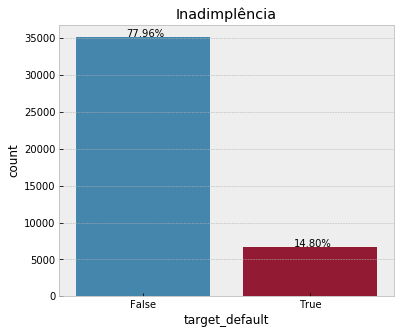

In [14]:
plt.figure(figsize=(6,5))
#plt.grid()
plt.title('Inadimplência')

ax = sns.countplot('target_default',data=acq_train)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(acq_train['target_default'])), (p.get_x()+ 0.3, p.get_height()+100))

In [15]:
sum(acq_train['target_default'].isna())/len(acq_train['target_default'])*100

7.242222222222222

Podemos observar que a base é altamente enviesada com relação à inadimplência - quase 78% de todos os registros são clientes adimplentes. Precisaremos levar isto em conta depois, ao criar um modelo de predição.
Note ainda, que cerca de 7% dos valores estão faltando no alvo adimplência. 

Analisamos agora a o alvo fraude.

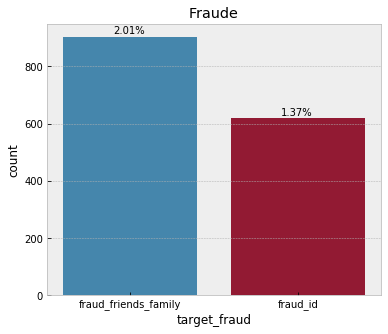

In [16]:
plt.figure(figsize=(6,5))
#plt.grid()
plt.title('Fraude')

ax = sns.countplot('target_fraud',data=acq_train)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(acq_train['target_fraud'])), (p.get_x()+ 0.3, p.get_height()+10))

Observamos do gráfico acima que cerca de 2% dos fraudadores na base de dados são da classe 'amigos ou parentes'; e 1.37% se encaixam nos demais tipos de fraude. É importante notar que os dois somam menos que 4% do total, o que significa que a vasta maioria das observações não possui uma informação com relação a fraude. Isso pode ocorrer em dois casos: ou a pessoa não é fraudadora, ou ainda não sabemos que ela o é.

Para fins de análise, vamos dar o benefício da dúvida àqueles que não possuem nenhuma informação sobre fraude e considerá-los isentos. Assim, a variável `target_fraud_bin` se torna o alvo para predição de fraude.

Dentre os fraudadores marcados como 'amigos ou família', há uma grande diferença entre adimplentes e inadimplentes, com uma propensão à inadimplência, como mostra o gráfico a seguir. Dentre os demais fraudadores, os números são quase os mesmos.

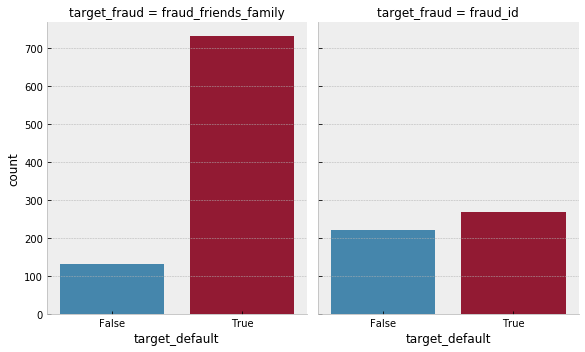

In [17]:
sns.catplot(x="target_default", kind="count",
            col="target_fraud", data=acq_train,
            height=5, aspect=.8)

### Mapa

Analisamos a seguir a distribuição no mapa dos casos de inadimplência. Em verde, temos todos os clientes; em vermelho, os casos de fraude. Podemos observar que há alguns *clusters* de fraude, onde a incidência é maior de pontos vermelhos.

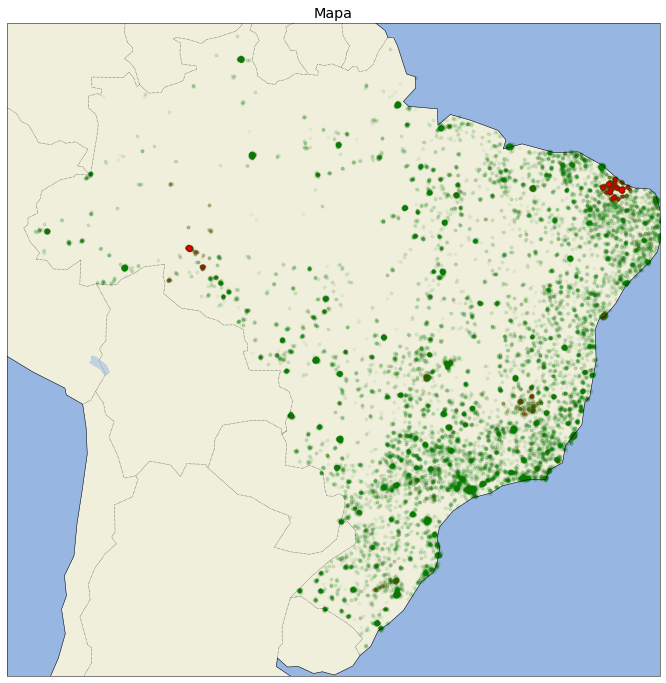

In [18]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-75, -35, -35, 5], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)


# Todos os pontos
ax.scatter(acq_train['lon'], 
            acq_train['lat'],
          alpha=0.05, s=10,c='green')

# Casos de fraude
ax.scatter(acq_train[~acq_train['target_fraud'].isna()]['lon'], 
            acq_train[~acq_train['target_fraud'].isna()]['lat'],
          alpha=0.05, s=10,c='red')

plt.title('Mapa dos casos de fraude')
plt.show()

O mesmo ocorre para casos de inadimplência, mas de forma mais espalhada. Novamente, no gráfico abaixo, temos em verde todos os clientes e em vermelho os casos de inadimplência.

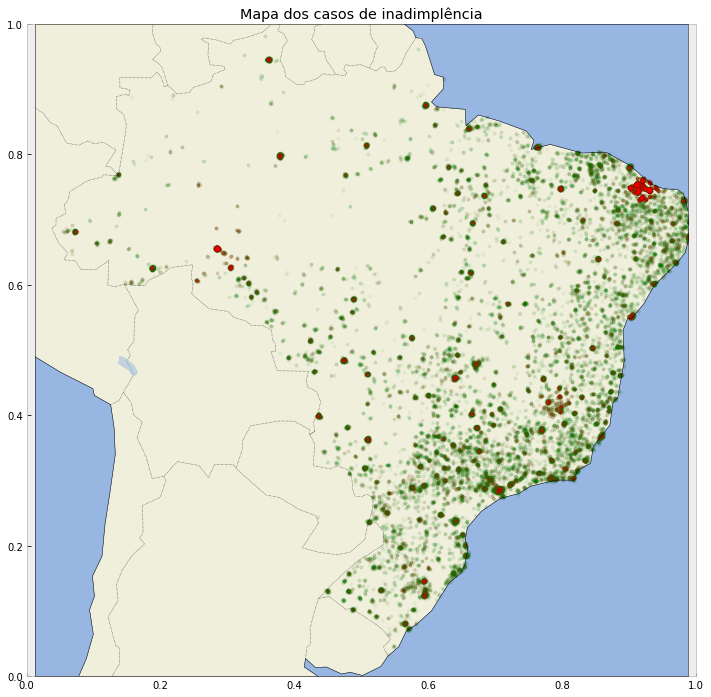

In [28]:
fig = plt.figure(figsize=(12, 12))
plt.grid()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-75, -35, -35, 5], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)

# Todos os pontos
ax.scatter(acq_train['lon'], 
            acq_train['lat'],
          alpha=0.05, s=10,c='green')

# Casos de inadimplência
ax.scatter(acq_train[acq_train['target_default']==True]['lon'], 
            acq_train[acq_train['target_default']==True]['lat'],
          alpha=0.05, s=10,c='red')

plt.title('Mapa dos casos de inadimplência')
plt.show()

### Horário da ligação

O gráfico a seguir mostra a distribuição dos horários de ligação para aqueles marcados como fraudadores ou não.
Enquanto para aqueles não marcados como fraude a distribuição se mantém mais ou menos a mesma, exceto pelo horário de meia-noite, para os casos de fraude há um aumento na madrugada.

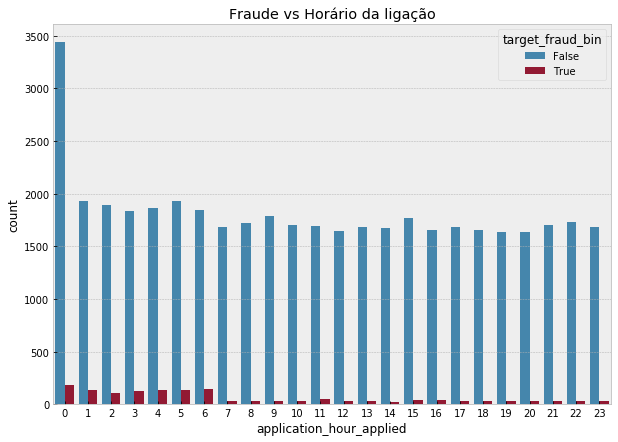

In [20]:
plt.figure(figsize=(10,7))
#plt.grid()
plt.title('Fraude vs Horário da ligação')
sns.countplot(x="application_hour_applied", hue="target_fraud_bin", data=acq_train)

Vemos a seguir que comportamento semelhante ocorre na inadimplência: o número de pedidos é maior durante a madrugada.

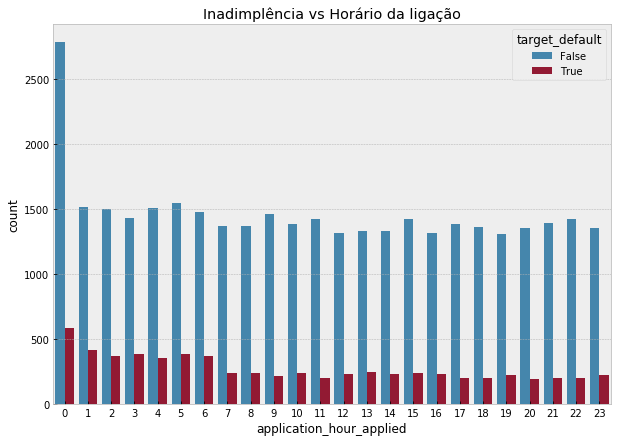

In [21]:
plt.figure(figsize=(10,7))
#plt.grid()
plt.title('Inadimplência vs Horário da ligação')
sns.countplot(x="application_hour_applied", hue="target_default", data=acq_train)

### Perfil do Facebook

Podemos observar no gráfico a seguir que a razão entre adimplentes e inadimplentes com facebook é maior que a razão daqueles sem, o que pode indicar uma relação entre a rede social e inadimplência.
Em termos absolutos, o número de inadimplentes com perfil é maior que o número de adimplentes.

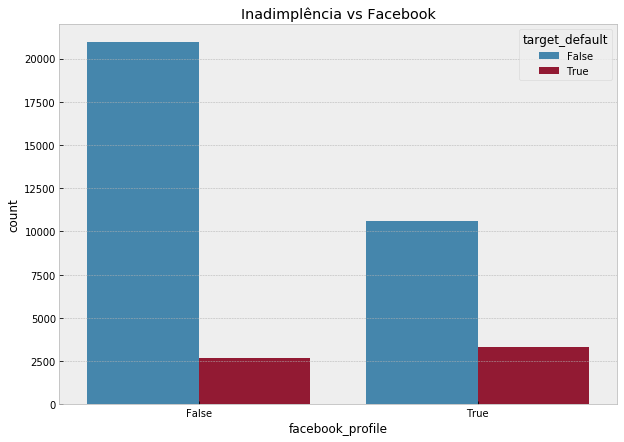

In [22]:
plt.figure(figsize=(10,7))
plt.title('Inadimplência vs Facebook')
sns.countplot(x="facebook_profile", hue="target_default", data=acq_train)

Comportamento similar ocorre, em menor grau contudo, nos casos de fraude.

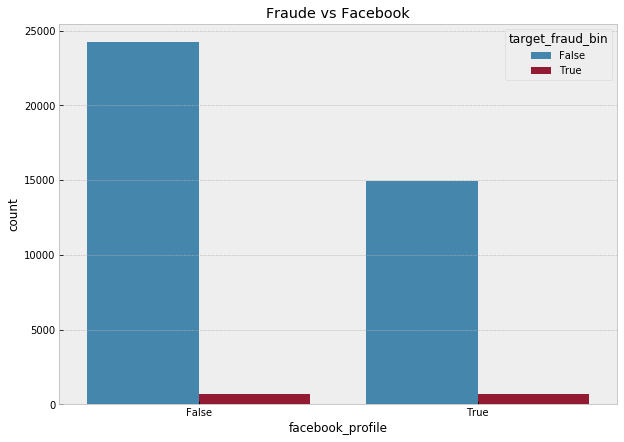

In [23]:
plt.figure(figsize=(10,7))
plt.title('Fraude vs Facebook')
sns.countplot(x="facebook_profile", hue="target_fraud_bin", data=acq_train)

### Tempo gasto no processo de aplicação

No gráfico a seguir observamos a relação entre o tempo gasto no processo de aplicação e inadimplência. A diferença se mantém praticamente a mesma em todo o gráfico, exceto quando o tempo é extremamente curto.

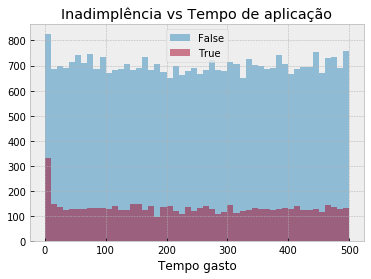

In [24]:
var = 'target_default'
i = 0
for v in acq_train[var].dropna().unique().tolist():
    color = 'C' + str(i)
    acq_train[acq_train[var]==v]['application_time_in_funnel'].hist(bins=50,alpha=0.5,color=color,label=str(v))
    i += 1

plt.title('Inadimplência vs Tempo de aplicação')
plt.xlabel('Tempo gasto')
plt.legend()

Comportamento semelhante ocorre para fraude, como vemos abaixo.

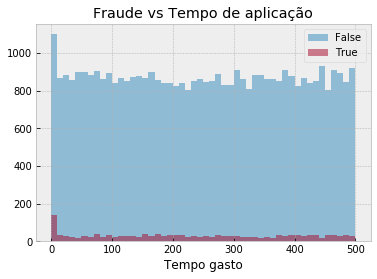

In [25]:
var = 'target_fraud_bin'
i = 0
for v in acq_train[var].dropna().unique().tolist():
    color = 'C' + str(i)
    acq_train[acq_train[var]==v]['application_time_in_funnel'].hist(bins=50,alpha=0.5,color=color,label=str(v))
    i += 1
    
plt.title('Fraude vs Tempo de aplicação')
plt.xlabel('Tempo gasto')
plt.legend()

## Valores ausentes (*Missing values*)

Analisaremos aqui os valores ausentes no conjunto de dados de aquisição. 
Para tal, utilizamos a biblioteca `missingno`, que permite a visualização sobre a densidade dos dados ausentes.

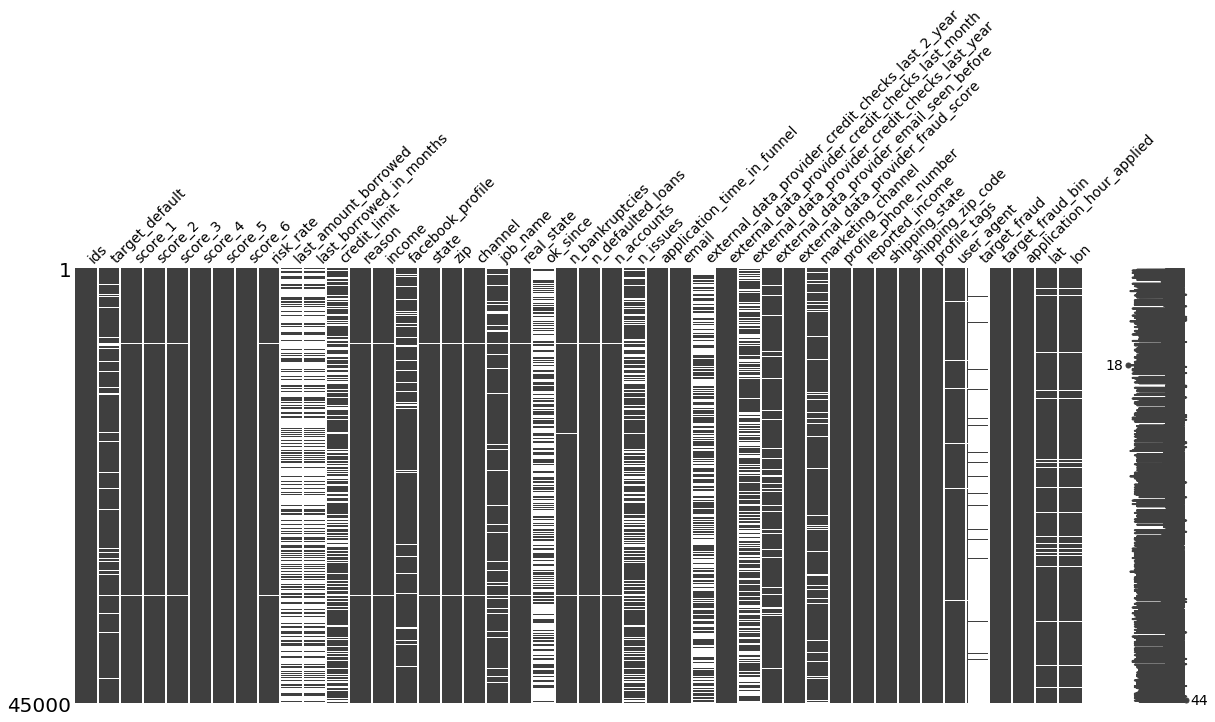

In [26]:
msno.matrix(acq_train,figsize=(20,8),fontsize=14)

  Algumas colunas, como `last_amount_borrowed` e `last_borrowed_in_months`, possuem diversos valores ausentes
  
  Além disso, aparentemente há correlação nos valores ausentes para alguns conjuntos de colunas. Por exemplo,
  * `last_amount_borrowed` e `last_borrowed_in_months`
  *  `score_1`,
 `score_2`,
 `score_3`,
 `risk_rate`,
 `reason`,
 `income`,
 `state`,
 `zip`,
 `channel`,
 `real_state`,
 `n_bankruptcies`,
 `n_defaulted_loans`,
 `n_accounts`
 
 Isso sugere que vieram de uma mesma fonte (que não possuía informação para aqueles clientes). A correlação pode ser confirmada no *heatmap* a seguir, onde as duas listas formam *clusters* de cor azul (alta correlação)

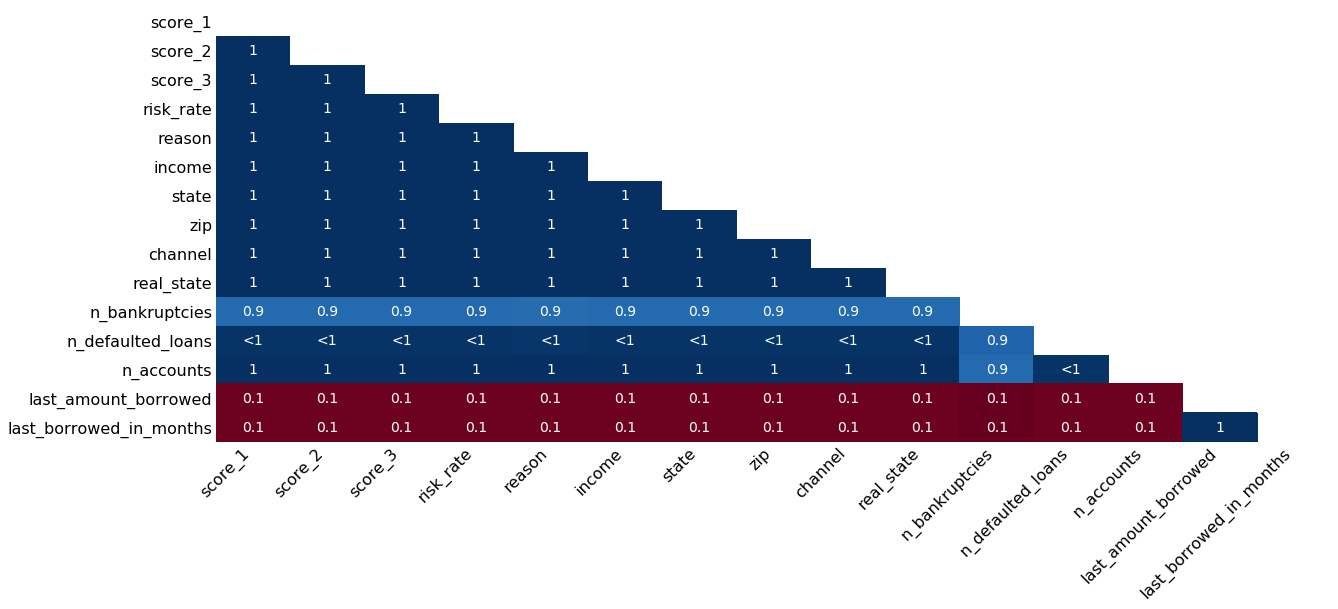

In [27]:
corr_var = ['score_1', 'score_2',
 'score_3',
 'risk_rate',
 'reason',
 'income',
 'state',
 'zip',
 'channel',
 'real_state',
 'n_bankruptcies',
 'n_defaulted_loans',
 'n_accounts',
 'last_amount_borrowed',
 'last_borrowed_in_months']
msno.heatmap(acq_train[corr_var],figsize=(20,8))